# Count of first class tickets for the next month.


# Import libraries


In [1]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.model_selection import GridSearchCV

import xgboost as xg
from sklearn.metrics import mean_squared_error, mean_absolute_error


# Load data

In [2]:
server = 'mohamedibrahim'
database = 'railway_dwh'

connection_string = (
    f'mssql+pyodbc://mohamedibrahim/railway_dwh'
    '?driver=ODBC+Driver+17+for+SQL+Server'
    '&Trusted_Connection=yes'
)
engine = create_engine(connection_string)

query = """
SELECT date_of_purchase,
COUNT(CASE WHEN ticket_class = 'Standard' THEN 1 END) AS Standard_Class_Count
FROM silver.railway
where month(date_of_purchase) != '12'
GROUP BY date_of_purchase
ORDER BY date_of_purchase
"""
df = pd.read_sql(query, engine)

# Preprocessing & Feature engineering

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121 entries, 0 to 120
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   date_of_purchase      121 non-null    object
 1   Standard_Class_Count  121 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.0+ KB


In [4]:
df['date_of_purchase'] = pd.to_datetime(df['date_of_purchase'])

In [5]:
df.head()

,date_of_purchase,Standard_Class_Count
0,2024-01-01,41
1,2024-01-02,251
2,2024-01-03,241
3,2024-01-04,252
4,2024-01-05,224


In [6]:
df.set_index('date_of_purchase', inplace=True)

In [7]:
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month
df['day'] = df.index.day

In [8]:
import holidays


uk_holidays = holidays.UnitedKingdom(subdiv='ENG', years=2024, observed=True)
df['is_holiday'] = df.index.map(lambda x: x in uk_holidays)


In [9]:
df['is_holiday'] = df['is_holiday'].astype(int)


In [10]:
df['lag 1'] = df['Standard_Class_Count'].shift(1).fillna(0)
df['lag 7'] = df['Standard_Class_Count'].shift(7).fillna(0)
df['lag 14'] = df['Standard_Class_Count'].shift(14).fillna(0)


In [11]:
df['lag 1'] = df['lag 1'].astype(int)
df['lag 7'] = df['lag 7'].astype(int)
df['lag 14'] = df['lag 14'].astype(int)

## Forecasting

## Prepare Train & Test data

In [12]:
train = df.loc[df.index < '2024-04-11']
test = df.loc[df.index >= '2024-04-11']

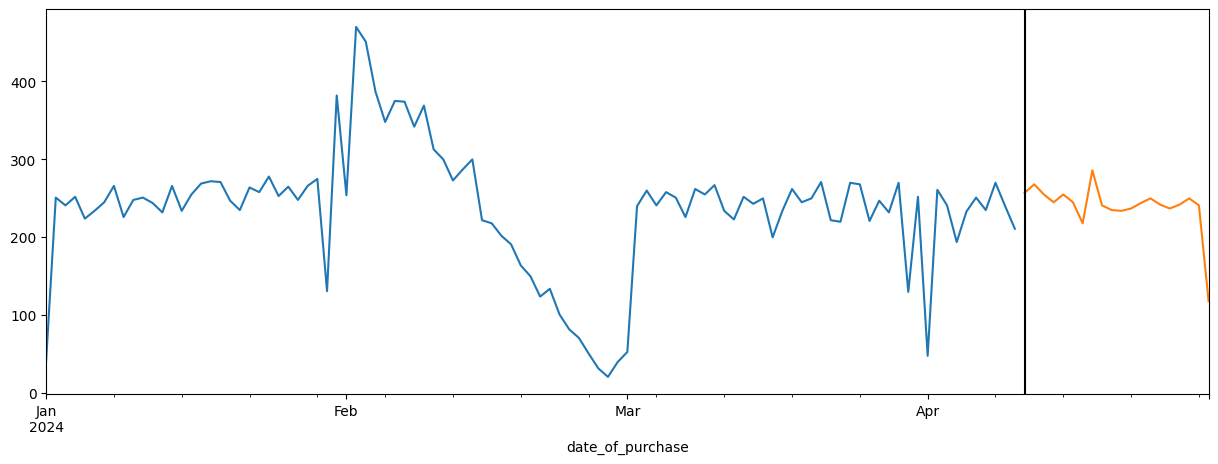

In [13]:
fig, ax = plt.subplots(figsize=(15,5))
train['Standard_Class_Count'].plot(ax=ax,label='tarining set')
test['Standard_Class_Count'].plot(ax=ax,label='test set')
ax.axvline('2024-04-11', color='black')
plt.show()


## Creat model

In [14]:
# define the features
features = [
    'month', 'day', 'day_of_week', 'is_holiday', 'lag 1', 'lag 7', 'lag 14'
    ]

In [15]:
# prepare the training data
x_train = train[features]
y_train = train['Standard_Class_Count']

x_test = test[features]
y_test = test['Standard_Class_Count']

In [157]:
# train XGBOOST model
model = xg.XGBRegressor(
    n_estimators = 200,          
    learning_rate = 0.03,          
    max_depth = 4,                 
    random_state = 42,             
)


model.fit(
    x_train, 
    y_train,
    eval_set=[(x_train, y_train), (x_test, y_test)],
    verbose=True
)



[0]	validation_0-rmse:79.97137	validation_1-rmse:31.40974
[1]	validation_0-rmse:78.44652	validation_1-rmse:31.35598
[2]	validation_0-rmse:76.97015	validation_1-rmse:31.30891
[3]	validation_0-rmse:75.54055	validation_1-rmse:31.26807
[4]	validation_0-rmse:74.15632	validation_1-rmse:31.23300
[5]	validation_0-rmse:72.81481	validation_1-rmse:31.20327
[6]	validation_0-rmse:71.51513	validation_1-rmse:31.17850
[7]	validation_0-rmse:70.25631	validation_1-rmse:31.11712
[8]	validation_0-rmse:69.03487	validation_1-rmse:31.10036
[9]	validation_0-rmse:67.85199	validation_1-rmse:31.08758
[10]	validation_0-rmse:66.70479	validation_1-rmse:31.03949
[11]	validation_0-rmse:65.59458	validation_1-rmse:31.03352
[12]	validation_0-rmse:64.51844	validation_1-rmse:30.98182
[13]	validation_0-rmse:63.47299	validation_1-rmse:30.98151
[14]	validation_0-rmse:62.45982	validation_1-rmse:30.98133
[15]	validation_0-rmse:61.47384	validation_1-rmse:30.96071
[16]	validation_0-rmse:60.51775	validation_1-rmse:30.96109
[17]	va

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.03, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, ...)

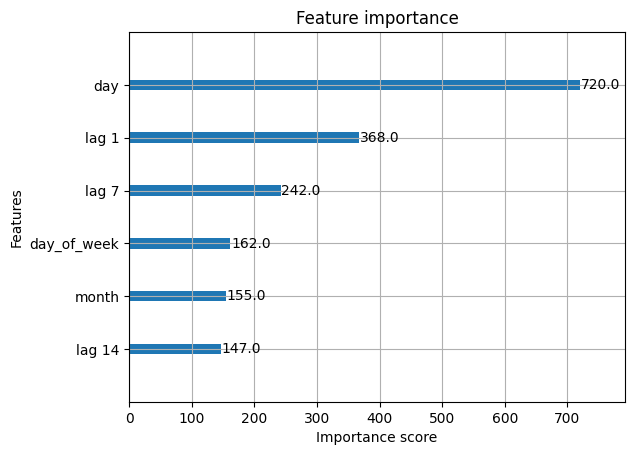

In [158]:
xg.plot_importance(model)
plt.show()


In [159]:
# Make predictions
train_preds = model.predict(x_train)
test_preds = model.predict(x_test)


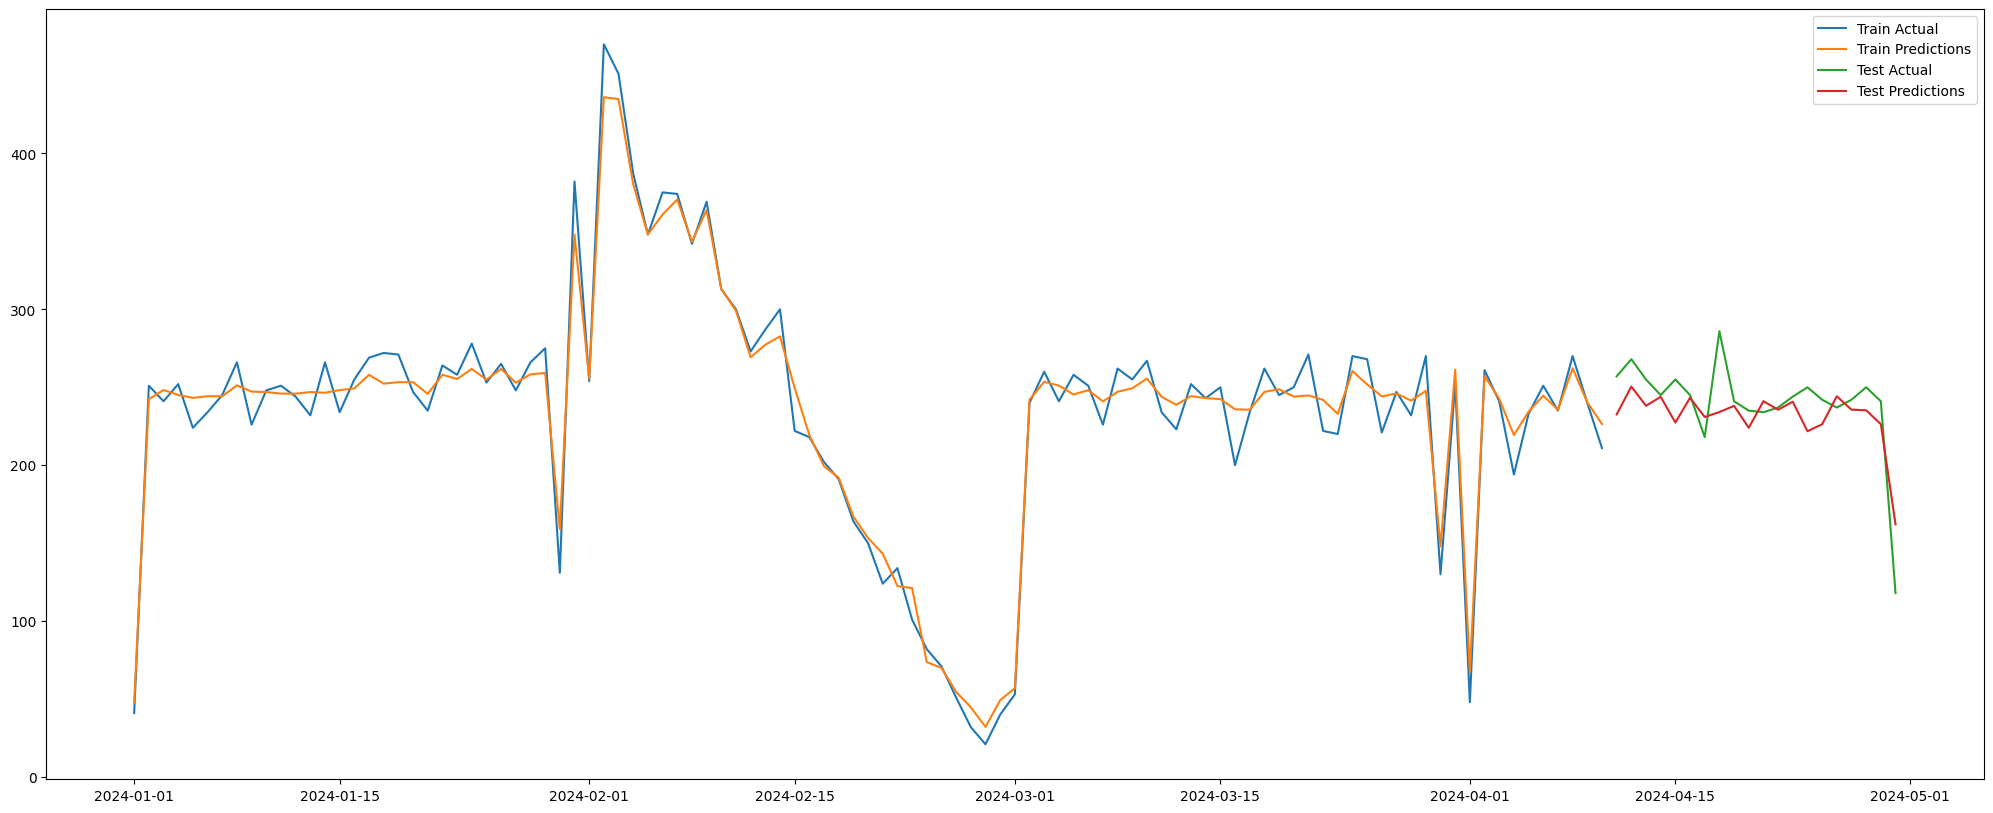

In [160]:
# Plot results
plt.figure(figsize=(25,10))
plt.plot(train.index, y_train, label='Train Actual')
plt.plot(train.index, pd.Series(train_preds), label='Train Predictions')
plt.plot(test.index, y_test, label='Test Actual')
plt.plot(test.index, pd.Series(test_preds), label='Test Predictions')
plt.legend()
plt.show()


## Forecasting the Next Month 


In [161]:

# Create a dataframe for the next 30 days
last_date = df.index.max()
next_month_dates = pd.date_range(start=last_date + timedelta(days=1), periods=30)
future_df = pd.DataFrame(index=next_month_dates)


In [162]:

# Prepare holiday map
future_df['day_of_week'] = future_df.index.dayofweek
future_df['month'] = future_df.index.month
future_df['day'] = future_df.index.day
future_df['is_holiday'] = future_df.index.map(lambda x: x in uk_holidays).astype(int)


In [163]:

# Copy original dataframe to append predictions for lag calculation
history = df.copy()

# Placeholder for predictions
predictions = []


In [164]:

# Forecast each day one by one 
for date in future_df.index:
    row = {}
    row['month'] = date.month
    row['day'] = date.day
    row['day_of_week'] = date.dayofweek
    row['is_holiday'] = int(date in uk_holidays)
    row['lag 1'] = history['Standard_Class_Count'].iloc[-1]
    row['lag 7'] = history['Standard_Class_Count'].iloc[-7] if len(history) >= 7 else 0
    row['lag 14'] = history['Standard_Class_Count'].iloc[-14] if len(history) >= 14 else 0

    # Predict
    features_row = pd.DataFrame([row])
    pred = model.predict(features_row)[0]

    # Store prediction
    predictions.append(pred)

    # Append to history to update lags for next iteration
    history = pd.concat([
        history,
        pd.DataFrame({'Standard_Class_Count': [pred]}, index=[date])
    ])


In [165]:

# Assign predictions to future_df
future_df['predicted_Standard_Class_Count'] = predictions


# Results

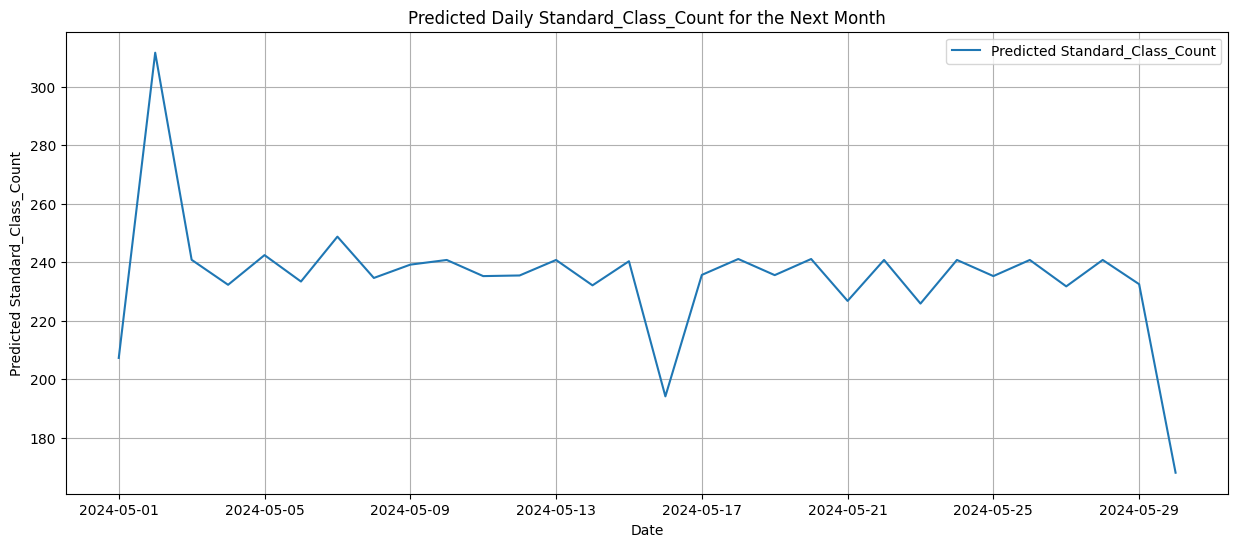


Predicted Daily Standard_Class_Count for the Next Month:
2024-05-01    207.246765
2024-05-02    311.573975
2024-05-03    240.784302
2024-05-04    232.244904
2024-05-05    242.389069
2024-05-06    233.358734
2024-05-07    248.703735
2024-05-08    234.582275
2024-05-09    239.135712
2024-05-10    240.730698
2024-05-11    235.215698
2024-05-12    235.431656
2024-05-13    240.730698
2024-05-14    232.056961
2024-05-15    240.296509
2024-05-16    194.107681
2024-05-17    235.623993
2024-05-18    241.060944
2024-05-19    235.545944
2024-05-20    241.060944
2024-05-21    226.731567
2024-05-22    240.735336
2024-05-23    225.821304
2024-05-24    240.735336
2024-05-25    235.220337
2024-05-26    240.735336
2024-05-27    231.705002
2024-05-28    240.735336
2024-05-29    232.453232
2024-05-30    168.005524
Freq: D, Name: predicted_Standard_Class_Count, dtype: float32


,day_of_week,month,day,is_holiday,predicted_Standard_Class_Count
2024-05-01,2,5,1,0,207.246765
2024-05-02,3,5,2,0,311.573975
2024-05-03,4,5,3,0,240.784302
2024-05-04,5,5,4,0,232.244904
2024-05-05,6,5,5,0,242.389069
2024-05-06,0,5,6,1,233.358734
2024-05-07,1,5,7,0,248.703735
2024-05-08,2,5,8,0,234.582275
2024-05-09,3,5,9,0,239.135712
2024-05-10,4,5,10,0,240.730698


In [166]:

# Plot forecasted Standard_Class_Count
plt.figure(figsize=(15, 6))
plt.plot(future_df.index, future_df['predicted_Standard_Class_Count'], label='Predicted Standard_Class_Count')
plt.title('Predicted Daily Standard_Class_Count for the Next Month')
plt.xlabel('Date')
plt.ylabel('Predicted Standard_Class_Count')
plt.legend()
plt.grid(True)
plt.show()

# Print forecasted values
print("\nPredicted Daily Standard_Class_Count for the Next Month:")
print(future_df['predicted_Standard_Class_Count'])
future_df
